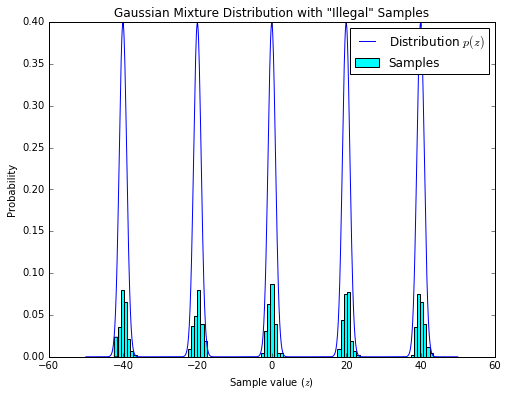

In [1]:
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab # Numerical python functions written for compatability with MATLAB commands with the same names.Numerical python functions written for compatability with MATLAB commands with the same names.

### ~~~~~ Original Distributions ~~~~~ ###

# Get Gaussian mixture distribution to sample from indirectly
# Inputs:
# K - number of Gaussians in mixture
# sizes - list containing number of samples for each Gaussian (we technically can't get this)
def gaussianMixture(K, sizes):
    
    if K > len(sizes):
        print('Specified K %d exceeds size of list %d' % (K, len(sizes)))
        return
    
    # Parameters to generate data with using for Gaussian
    x_range = 50 #distribute clusters so that means are evenly separated from -x_range to x_range
    mu = [-x_range + x_range/float(K) + 2*k*x_range/float(K) for k in range(K)]
    sigma = [1 for k in range(K)] #just use 1 for variance for simplicity

    # Get the Gaussian mixture distribution using params by adding the individual distributions together
    n = 1000 #number of distribution points to calculate
    p_pdf = np.zeros(n) #initialize distribution to 0 before adding in each Gaussian
    x_pdf = np.linspace(-x_range,x_range,n) #range of values to calculate distribution
    for k in range(K):
        p_pdf += mlab.normpdf(x_pdf,mu[k],sigma[k])

    # Generate data samples from Gaussian using params
    # Call ravel because don't want lists within lists, just want one list of data
    X = np.ravel([np.random.normal(mu[k],sigma[k],sizes[k]) for k in range(K)])
    
    # Outputs:
    # mu - means of all Gaussians in mixture (K element list)
    # sigma - variance of all Gaussians in mixture (K element list)
    # x_pdf - range of values that pdf is calculated over
    # p_pdf - probability density values calculated over x_pdf
    # X - samples generated from distribution (just for comparison, we're technically not able to generate this)
    return mu, sigma, x_pdf, p_pdf, X


# Get parameters, distribution, and samples from Gaussian mixture
K = 5
sizes = [100 for k in range(K)]
(mu_GM, sigma_GM, x_pdf_GM, p_pdf_GM, X_GM) = gaussianMixture(K,sizes)
#print X_GM, X_GM.shape, type(X)

# Plot original distribution p with samples
# We're technically not supposed to know these samples, we plot them just for comparison purposes
figsize = (8,6)
plt.figure(figsize=figsize)
plt.plot(x_pdf_GM,p_pdf_GM,color='blue',label='Distribution $p(z)$')
plt.hist(X_GM,bins=100,color='cyan',normed=True, label='Samples')
plt.title('Gaussian Mixture Distribution with \"Illegal\" Samples')
plt.xlabel('Sample value ($z$)')
plt.ylabel('Probability')
plt.legend(loc='upper right')
plt.show()


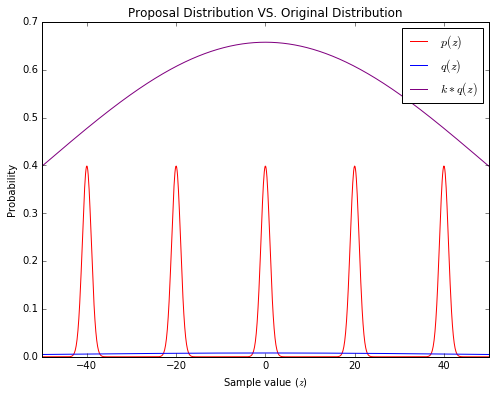

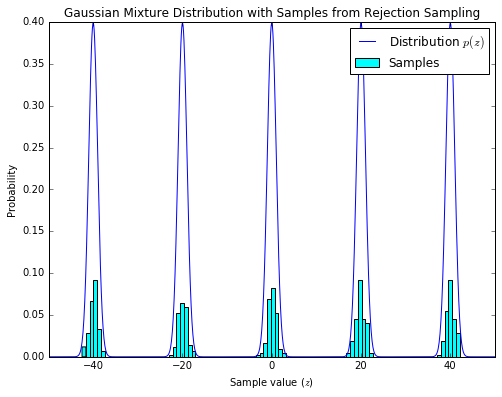

In [2]:
### ~~~~~ Rejection Sampling ~~~~~ ###

# Inputs:
# N - number of samples to generate
# p_params - dictionary containing parameters of distribution (key names are dependent on distribution)
def rejectionSampling(N, p_params):
    
    # Use Gaussian distribution for proposal distribution
    # Find k such that scaled proposal distribution is higher than all values of p (or the max of p)    
    
    # First generate a test proposal with high variance to account for a greater range
    x_range = 50 #determines range of points to generate for pdf
    n_pdf = 1000 #number of points to generate for pdf
    x_pdf = np.linspace(-x_range,x_range,n_pdf) #points to calculate distribution over
    q_pdf = mlab.normpdf(x_pdf,0,x_range) #variance is just x_range
    
    # Generate p using the same range of values
    if p_params['type'] == 'gaussian_mixture':
        p_pdf = np.zeros(n_pdf)
        for i in range(p_params['K']):
            p_pdf += mlab.normpdf(x_pdf,p_params['mu'][i],p_params['sigma'][i])
    
    # Take k as the ratio between the maxes of p_pdf and the min test q_pdf to scale q_pdf up
    k = np.amax(p_pdf)/np.amin(q_pdf)
    
    # Plot scaled proposal distribution against actual
    figsize = (8,6)
    plt.figure(figsize=figsize)
    plt.plot(x_pdf,p_pdf,color='red',label="$p(z)$")
    plt.plot(x_pdf,q_pdf,color='blue',label="$q(z)$")
    plt.plot(x_pdf,k*q_pdf,color='purple',label="$k*q(z)$")
    plt.xlim([-x_range,x_range])
    plt.title("Proposal Distribution VS. Original Distribution")
    plt.xlabel('Sample value ($z$)')
    plt.ylabel('Probability')
    plt.legend(loc="upper right")
    plt.show()
    
    # Now sample from proposal distribution and perform rejection sampling
    X = np.zeros(N)
    n_accepted = 0 #keeps track of number of samples accepted
    
    # Continue to sample until you've accepted the specified number of sample
    while True:
        
        # Step 1: Generate z0 from q(z)
        z0 = np.random.normal(0,x_range)
        
        # Step 2: Generate uniform u0 from [0,k*q(z0)]
        qz0 = mlab.normpdf(z0,0,x_range)
        u0 = np.random.uniform(0,k*qz0)
        
        # Step 2.5: Calculate p(z0)
        if p_params['type'] == 'gaussian_mixture':
            pz0 = 0
            for j in range(p_params['K']):
                pz0 += mlab.normpdf(z0,p_params['mu'][j],p_params['sigma'][j])
                
        # Accept if u0 <= p(z0), reject otherwise
        if u0 <= pz0:
            X[n_accepted] = z0
            n_accepted += 1

        # Break if you've accepted the appropriate number of samples
        if n_accepted == N:
            break
            
    return X

        
# These parameters are exclusive to Gaussian mixture
p_params_GM = {}
p_params_GM['type'] = 'gaussian_mixture'
p_params_GM['mu'] = mu_GM
p_params_GM['sigma'] = sigma_GM
p_params_GM['K'] = K
X_RS = rejectionSampling(500,p_params_GM)

figsize = (8,6)
plt.figure(figsize=figsize)
plt.plot(x_pdf_GM,p_pdf_GM,color='blue',label='Distribution $p(z)$')
plt.hist(X_RS,bins=100,color='cyan',normed=True,label='Samples')
plt.title('Gaussian Mixture Distribution with Samples from Rejection Sampling')
plt.xlabel('Sample value ($z$)')
plt.ylabel('Probability')
plt.legend(loc="upper right")
plt.xlim([-50,50])
plt.show()
    

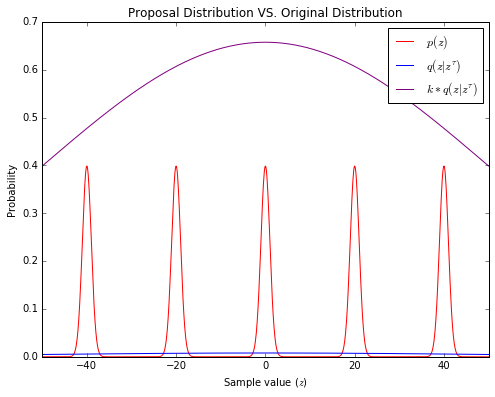

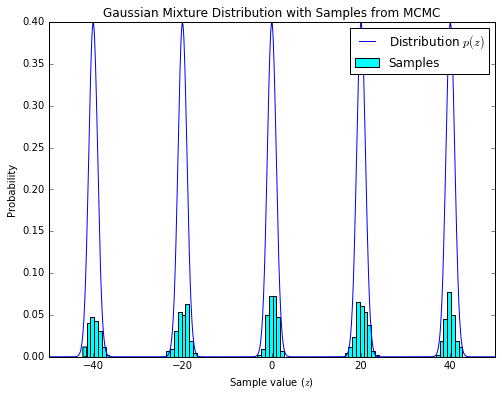

In [3]:
### ~~~~~ MCMC ~~~~~ ###

# Parameters:
# N - number of samples to generate
# p_params - parameters of distribution in a dictionary
def MCMC(N, p_params):
    
    # Generate the proposal distribution q using the same method as in rejectionSampling
    x_range = 50 #determines range of points to generate for pdf
    n_pdf = 1000 #number of points to generate for pdf
    x_pdf = np.linspace(-x_range,x_range,n_pdf) #points to calculate distribution over
    q_pdf = mlab.normpdf(x_pdf,0,x_range) #variance is just x_range
    
    # Generate p using the same range of values
    if p_params['type'] == 'gaussian_mixture':
        p_pdf = np.zeros(n_pdf)
        for i in range(p_params['K']):
            p_pdf += mlab.normpdf(x_pdf,p_params['mu'][i],p_params['sigma'][i])
    
    # Take k as the ratio between the maxes of p_pdf and the min test q_pdf to scale q_pdf up
    k = np.amax(p_pdf)/np.amin(q_pdf)
    
    # Plot scaled proposal distribution against actual
    figsize = (8,6)
    plt.figure(figsize=figsize)
    plt.plot(x_pdf,p_pdf,color='red',label="$p(z)$")
    plt.plot(x_pdf,q_pdf,color='blue',label=r"$q(z|z^\tau)$") #need to put r before quotes to specify raw text
    plt.plot(x_pdf,k*q_pdf,color='purple',label=r"$k*q(z|z^\tau)$") #else \t will register as tab
    plt.xlim([-x_range,x_range])
    plt.title("Proposal Distribution VS. Original Distribution")
    plt.xlabel('Sample value ($z$)')
    plt.ylabel('Probability')
    plt.legend(loc="upper right")
    plt.show()
    
    # Now sample from proposal distribution and use MCMC to determine acceptance or rejection
    X = np.zeros(N)
    n_accepted = 0 #keeps track of number of samples accepted
    
    # Continue to sample until you've accepted the specified number of sample
    while True:
        
        # Step 1: Sample z* from q(z|z^T)
        zstar = np.random.normal(0,x_range)
        
        # Step 1.5: Get p(z*)
        if p_params['type'] == 'gaussian_mixture':    
            p_zstar = 0
            for j in range(p_params['K']):
                p_zstar += mlab.normpdf(zstar,p_params['mu'][j],p_params['sigma'][j])

        # Step 2: Get probability of acceptance for current sample
        if n_accepted == 0:
            A_zstar = 1 #if no samples yet, take first sample with acceptance probability 1
        else:
            if p_zT == 0: #account for divide by 0, since p(z^T) is in denominator in acceptance prob calculation
                A_zstar = 1
            else:        
                A_zstar = min(1, float(p_zstar)/p_zT)
                
        # Step 3: Generate uniform u from [0,1]
        u = np.random.uniform(0,1)
    
        # Step 4: Accept if A(z*,z^T) > u, and store the sample as the current state
        # Otherwise reject the sample and keep the current state as the previous state
        if A_zstar > u:
            X[n_accepted] = zstar
            p_zT = p_zstar
            n_accepted += 1

        # Break if you've accepted the appropriate number of samples
        if n_accepted == N:
            break
            
    return X

        
# These parameters are exclusive to Gaussian mixture
p_params_GM = {}
p_params_GM['type'] = 'gaussian_mixture'
p_params_GM['mu'] = mu_GM
p_params_GM['sigma'] = sigma_GM
p_params_GM['K'] = K
X_MCMC = MCMC(500,p_params_GM)

figsize = (8,6)
plt.figure(figsize=figsize)
plt.plot(x_pdf_GM,p_pdf_GM,color='blue',label='Distribution $p(z)$')
plt.hist(X_MCMC,bins=100,color='cyan',normed=True,label='Samples')
plt.title('Gaussian Mixture Distribution with Samples from MCMC')
plt.xlabel('Sample value ($z$)')
plt.ylabel('Probability')
plt.legend(loc="upper right")
plt.xlim([-50,50])
plt.show()
    